# Imports

In [ ]:
from __future__ import print_function
import tensorflow as tf
import numpy as np
from sklearn.metrics import accuracy_score, classification_report, precision_recall_fscore_support
from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras.datasets import mnist, fashion_mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, LeakyReLU, PReLU, ReLU, ELU, Input
from tensorflow.keras import activations
from tensorflow.keras.optimizers import RMSprop
from tensorboard.plugins.hparams import api as hp
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from enum import Enum
from dataclasses import dataclass
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K
from functools import partial
from matplotlib import pyplot as plt

# Constants

In [ ]:
BATCH_SIZE = 128
NUM_CLASSES = 10
EPOCHS = 30
logs_dir = 'logs/models'

# Dataset

In [ ]:
from dataclasses import dataclass
from sklearn.utils import shuffle
TRAIN_SET_RATE = 0.65
VALID_SET_RATE = 0.15
TEST_SET_RATE = 0.20

@dataclass
class Dataset():
  name: str
  x_train: object
  y_train: object
  x_valid: object
  y_valid: object
  x_test: object
  y_test: object
  y_test_labels: object

def get_permuted_dataset(dataset, name, permutation=False, model_type="MLP"):
  (x_train, y_train), (x_test, y_test) = dataset.load_data()

  X = np.concatenate((x_train, x_test))
  y = np.concatenate((y_train, y_test))

  if model_type == "MLP":
    X = X.reshape(X.shape[0], 784)

  X = X.astype('float32')
  X /= 255
  
  if permutation:
    X = np.random.permutation(X.T).T 

  x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SET_RATE, random_state=42)
  x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, test_size=VALID_SET_RATE, random_state=42)

  y_train = keras.utils.to_categorical(y_train, NUM_CLASSES)
  y_valid = keras.utils.to_categorical(y_valid, NUM_CLASSES)
  y_test_labels = y_test
  y_test = keras.utils.to_categorical(y_test, NUM_CLASSES)
  
  return Dataset(
      name=name,
      x_train=x_train,
      y_train=y_train,
      x_valid=x_valid,
      y_valid=y_valid,
      x_test=x_test,
      y_test=y_test,
      y_test_labels=y_test_labels
  )



## Effect of permutation on pixels

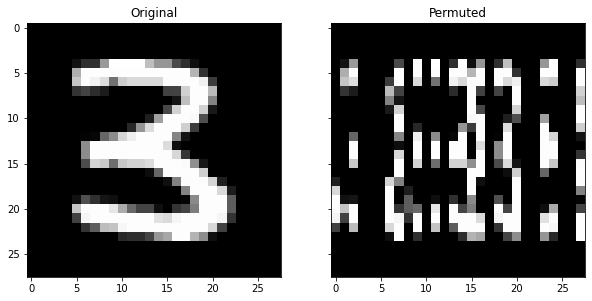

In [ ]:
digits_dataset = get_permuted_dataset(mnist, 'mnist', permutation=False, model_type="CNN")
permuted_digits_dataset = get_permuted_dataset(mnist, 'permutated_digits', permutation=True, model_type="CNN")

fig, axs = plt.subplots(1, 2, figsize=(10, 5), sharex=False, sharey=True)

axs[0].imshow(digits_dataset.x_valid[41], cmap='gray')
axs[0].set_title("Original")
axs[1].imshow(permuted_digits_dataset.x_valid[41], cmap='gray')
axs[1].set_title("Permuted")

plt.show()

# Models

## MLP

In [ ]:
def mlp_model():
  model = Sequential()
  model.add(Dense(512, activation='relu', input_shape=(784,)))
  model.add(Dropout(0.2))
  model.add(Dense(512, activation='relu'))
  model.add(Dropout(0.2))
  model.add(Dense(NUM_CLASSES, activation='softmax'))

  model.compile(loss='categorical_crossentropy',
                optimizer=RMSprop(),
                metrics=['accuracy'])
  
  model.summary()
  
  return model


## CNN

In [ ]:
def cnn_model(X):
  model = Sequential()
  model.add(Input(shape=(X.shape[1], X.shape[2], 1)))
  model.add(Conv2D(filters=64, kernel_size=7, activation='relu', padding='SAME'))
  model.add(MaxPooling2D(pool_size=1))

  model.add(Conv2D(filters=128, kernel_size=3, activation='relu', padding='SAME'))
  model.add(Conv2D(filters=128, kernel_size=3, activation='relu', padding='SAME'))

  model.add(MaxPooling2D(pool_size=1))
  model.add(Conv2D(filters=256, kernel_size=3, activation='relu', padding='SAME'))
  model.add(Conv2D(filters=256, kernel_size=3, activation='relu', padding='SAME'))
  model.add(MaxPooling2D(pool_size=1))
  
  model.add(Flatten())

  model.add(Dense(128, activation='relu'))
  model.add(Dropout(0.5))
  model.add(Dense(64, activation='relu'))
  model.add(Dropout(0.5))

  model.add(Dense(NUM_CLASSES, activation='softmax'))

  model.compile(loss='categorical_crossentropy', optimizer=RMSprop(), metrics=['accuracy'])
  
  model.build()
  model.summary()

  return model

## Running a model

In [ ]:

def run(model, model_name, dataset):
  model.fit(
    dataset.x_train,
    dataset.y_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=(dataset.x_valid, dataset.y_valid),
    callbacks=[
        keras.callbacks.EarlyStopping(patience=10),
    ],
  )

  test_score = model.evaluate(dataset.x_test, dataset.y_test, verbose=0)
  y_true = dataset.y_test_labels
  y_pred_probabilities = model.predict(dataset.x_test)
  y_pred = y_pred_probabilities.argmax(axis=-1)
  precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='weighted')
  train_score = model.evaluate(dataset.x_train, dataset.y_train, verbose=0)
  return train_score[1], test_score[1], f1

# Running experiments

## MLP

In [ ]:
BASELINE_DIGITS_DATASET = get_permuted_dataset(mnist, 'permutated_digits', permutation=False)
BASELINE_FASHION_DATASET = get_permuted_dataset(fashion_mnist, 'permuted_fashion', permutation=False)
PERMUTED_DIGITS_DATASET = get_permuted_dataset(mnist, 'permutated_digits', permutation=True)
PERMUTED_FASHION_DATASET = get_permuted_dataset(fashion_mnist, 'permuted_fashion', permutation=True)

### Baseline

In [ ]:
_, mlp_digits_test_accuracy, mlp_digits_f1_score = run(mlp_model(), 'MLP on permuted digits mnist', BASELINE_DIGITS_DATASET)
_, mlp_fashion_test_accuracy, mlp_fashion_f1_score = run(mlp_model(), 'MLP on permuted fashion mnist', BASELINE_FASHION_DATASET)

print(f'MLP Test accuracy on digits MNIST: {mlp_digits_test_accuracy}')
print(f'MLP F1 score on digits MNIST: {mlp_digits_f1_score}')
print(f'MLP Test accuracy on fashion MNIST: {mlp_fashion_test_accuracy}')
print(f'MLP F1 score on fashion MNIST: {mlp_fashion_f1_score}')

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 512)               401920    
                                                                 
 dropout_4 (Dropout)         (None, 512)               0         
                                                                 
 dense_7 (Dense)             (None, 512)               262656    
                                                                 
 dropout_5 (Dropout)         (None, 512)               0         
                                                                 
 dense_8 (Dense)             (None, 10)                5130      
                                                                 
Total params: 669,706
Trainable params: 669,706
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_2"
__________________________

### Permuted

In [ ]:
_, mlp_digits_test_accuracy, mlp_digits_f1_score = run(mlp_model(), 'MLP on permuted digits mnist', PERMUTED_DIGITS_DATASET)
_, mlp_fashion_test_accuracy, mlp_fashion_f1_score = run(mlp_model(), 'MLP on permuted fashion mnist', PERMUTED_FASHION_DATASET)

print(f'MLP Test accuracy on digits MNIST: {mlp_digits_test_accuracy}')
print(f'MLP F1 score on digits MNIST: {mlp_digits_f1_score}')
print(f'MLP Test accuracy on fashion MNIST: {mlp_fashion_test_accuracy}')
print(f'MLP F1 score on fashion MNIST: {mlp_fashion_f1_score}')

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 512)               401920    
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 512)               262656    
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                                 
 dense_2 (Dense)             (None, 10)                5130      
                                                                 
Total params: 669,706
Trainable params: 669,706
Non-trainable params: 0
_________________________________________________________________
Model: "sequential"
______________________________

## CNN

In [ ]:
BASELINE_DIGITS_DATASET = get_permuted_dataset(mnist, 'permutated_digits', permutation=False, model_type="CNN")
BASELINE_FASHION_DATASET = get_permuted_dataset(fashion_mnist, 'permuted_fashion', permutation=False, model_type="CNN")
PERMUTED_DIGITS_DATASET = get_permuted_dataset(mnist, 'permutated_digits', permutation=True, model_type="CNN")
PERMUTED_FASHION_DATASET = get_permuted_dataset(fashion_mnist, 'permuted_fashion', permutation=True, model_type="CNN")

4431872/4422102 [==============================] - 0s 0us/step


### Baseline

In [ ]:
_, cnn_digits_test_accuracy, cnn_digits_f1_score = run(cnn_model(BASELINE_DIGITS_DATASET.x_train), 'CNN on permuted digits mnist', BASELINE_DIGITS_DATASET)
_, cnn_fashion_test_accuracy, cnn_fashion_f1_score = run(cnn_model(BASELINE_FASHION_DATASET.x_train), 'CNN on permuted fashion mnist', BASELINE_FASHION_DATASET)

print(f'CNN Test accuracy on digits MNIST: {cnn_digits_test_accuracy}')
print(f'CNN F1 score on digits MNIST: {cnn_digits_f1_score}')
print(f'CNN Test accuracy on fashion MNIST: {cnn_fashion_test_accuracy}')
print(f'CNN F1 score on fashion MNIST: {cnn_fashion_f1_score}')

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_15 (Conv2D)          (None, 28, 28, 64)        3200      
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 28, 28, 64)       0         
 2D)                                                             
                                                                 
 conv2d_16 (Conv2D)          (None, 28, 28, 128)       73856     
                                                                 
 conv2d_17 (Conv2D)          (None, 28, 28, 128)       147584    
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 28, 28, 128)      0         
 g2D)                                                            
                                                                 
 conv2d_18 (Conv2D)          (None, 28, 28, 256)      

### Permuted

In [ ]:
_, cnn_digits_test_accuracy, cnn_digits_f1_score = run(cnn_model(PERMUTED_DIGITS_DATASET.x_train), 'CNN on permuted digits mnist', PERMUTED_DIGITS_DATASET)
_, cnn_fashion_test_accuracy, cnn_fashion_f1_score = run(cnn_model(PERMUTED_FASHION_DATASET.x_train), 'CNN on permuted fashion mnist', PERMUTED_FASHION_DATASET)

print(f'CNN Test accuracy on digits MNIST: {cnn_digits_test_accuracy}')
print(f'CNN F1 score on digits MNIST: {cnn_digits_f1_score}')
print(f'CNN Test accuracy on fashion MNIST: {cnn_fashion_test_accuracy}')
print(f'CNN F1 score on fashion MNIST: {cnn_fashion_f1_score}')

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_25 (Conv2D)          (None, 28, 28, 64)        3200      
                                                                 
 max_pooling2d_15 (MaxPoolin  (None, 28, 28, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_26 (Conv2D)          (None, 28, 28, 128)       73856     
                                                                 
 conv2d_27 (Conv2D)          (None, 28, 28, 128)       147584    
                                                                 
 max_pooling2d_16 (MaxPoolin  (None, 28, 28, 128)      0         
 g2D)                                                            
                                                                 
 conv2d_28 (Conv2D)          (None, 28, 28, 256)      